# Recommendation System Basic 과제

- 제출자: 20기 황태연
- 제출 일자: 2023.09.19.

**[과제]**
1. 파이썬을 이용하여 무비렌즈(ml-latest-small) 데이터를 전처리 및 EDA를 진행하여 유의미한 분석 5개 이상 보여주세요.
2. Memory based CF 2개 이상, Model based CF 1개 이상 알고리즘을 사용해서 '성능 평가'와 '추천 결과'를 출력해주세요.

# 1. Preprocessing & EDA

- 데이터를 불러오고 확인해보자.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [12]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [13]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [14]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


- timestamp는 제거하여 전처리하자.

In [20]:
ratings = ratings.drop(columns=['timestamp'])

In [23]:
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


## 1.1. 영화 장르 비율

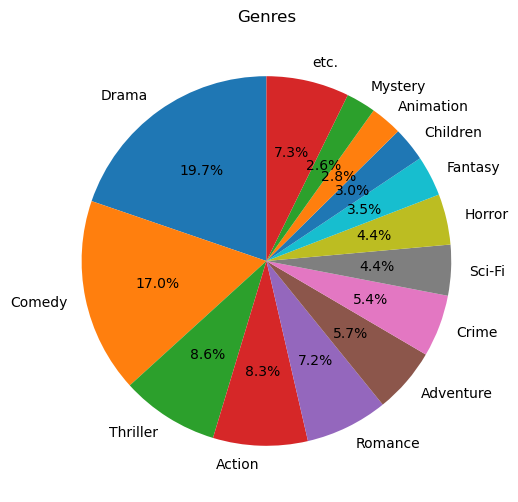

In [80]:
genres = movies['genres'].str.split('|')

genres_list = []

for genre_list in genres:
    genres_list.extend(genre_list)

genres_counts = pd.Series(genres_list).value_counts()

genres_counts['etc.'] = 0
for index in genres_counts.index:
    if genres_counts[index] < int(sum(genres_counts)/100 * 2): # 2% 미만은 모두 'etc.' 처리
        genres_counts['etc.'] += genres_counts[index]
        genres_counts = genres_counts.drop(index)

plt.figure(figsize=(10, 6))
plt.pie(genres_counts, labels=genres_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Genres')
plt.show()

## 1.2. 평점 비율

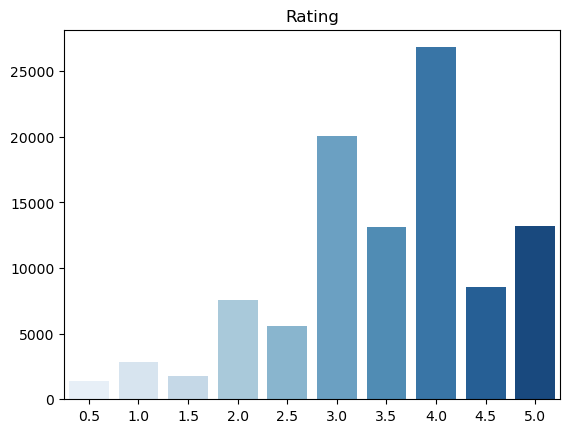

In [106]:
stars = ratings['rating']

stars_counts = stars.value_counts()

stars_indices = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
stars_counts = [stars_counts[index] for index in stars_indices]

sns.barplot(x=stars_indices, y=stars_counts, palette="Blues")
plt.title('Rating')
plt.show()

## 1.3. 개인별 영화 관람 횟수

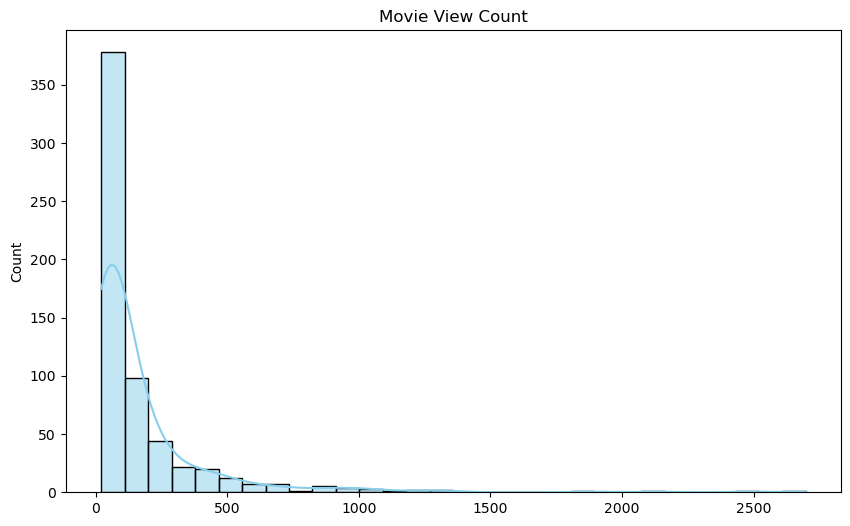

In [173]:
from collections import Counter

movie_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))

sns.histplot(movie_counts.values, bins=30, kde=True, color='skyblue')

plt.title('Movie View Count')
plt.show()

# 2. Recommendation System

## 2.1. Memory Based CF(Collaborative Filtering)

- 먼저, surprise 라이브러리를 사용하여 학습할 수 있도록 데이터를 전처리하자.

In [177]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings, reader)

X_train, X_test = train_test_split(data, test_size=0.2)

### 2.1.1. User Based

In [225]:
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

model.fit(X_train)

predictions = model.test(X_test)

accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9754


0.9753649376471903

- 1번 유저에게 (봤던 영화를 포함하여) 영화를 추천해보자.

In [226]:
movies_indices = movies['movieId'].unique()
movies_indices

array([     1,      2,      3, ..., 193585, 193587, 193609], dtype=int64)

In [227]:
from collections import defaultdict

user1_RS = defaultdict(list)
for i in movies_indices:
    uid, iid, true_r, est, _ = model.predict(1, i)
    user1_RS[i] = est
    
user1_RS = dict(sorted(user1_RS.items(), key=lambda item: item[1], reverse=True))

print("===== < Recommendation > =====")
count = 0
for iid, est in user1_RS.items():
    print(f"{count+1}. {movies[movies['movieId'] == iid]['title'].values[0]}")
    count += 1
    if count == 20:
        break

===== < Recommendation > =====
1. Lamerica (1994)
2. Awfully Big Adventure, An (1995)
3. Far From Home: The Adventures of Yellow Dog (1995)
4. Live Nude Girls (1995)
5. In the Realm of the Senses (Ai no corrida) (1976)
6. What Happened Was... (1994)
7. Thin Line Between Love and Hate, A (1996)
8. Supercop 2 (Project S) (Chao ji ji hua) (1993)
9. Microcosmos (Microcosmos: Le peuple de l'herbe) (1996)
10. Lesson Faust (1994)
11. Hype! (1996)
12. Vampire in Venice (Nosferatu a Venezia) (Nosferatu in Venice) (1986)
13. Cement Garden, The (1993)
14. For Roseanna (Roseanna's Grave) (1997)
15. Assignment, The (1997)
16. Wings of the Dove, The (1997)
17. Red Corner (1997)
18. Four Days in September (O Que É Isso, Companheiro?) (1997)
19. Blackbeard's Ghost (1968)
20. Mephisto (1981)


### 2.1.2. Item Based

In [228]:
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)

model.fit(X_train)

predictions = model.test(X_test)

accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9771


0.977144617583913

- 마찬가지로, 1번 유저에게 (봤던 영화를 포함하여) 영화를 추천해보자.

In [229]:
from collections import defaultdict

user1_RS = defaultdict(list)
for i in movies_indices:
    uid, iid, true_r, est, _ = model.predict(1, i)
    user1_RS[i] = est
    
user1_RS = dict(sorted(user1_RS.items(), key=lambda item: item[1], reverse=True))

print("===== < Recommendation > =====")
count = 0
for iid, est in user1_RS.items():
    print(f"{count+1}. {movies[movies['movieId'] == iid]['title'].values[0]}")
    count += 1
    if count == 20:
        break

===== < Recommendation > =====
1. Circus (2000)
2. 4 Little Girls (1997)
3. Galaxy of Terror (Quest) (1981)
4. Looker (1981)
5. Devil and Daniel Johnston, The (2005)
6. Fullmetal Alchemist: The Sacred Star of Milos (2011)
7. Mom's Night Out (2014)
8. The Hungover Games (2014)
9. The Stanford Prison Experiment (2015)
10. The Jinx: The Life and Deaths of Robert Durst (2015)
11. Steve Jobs: The Man in the Machine (2015)
12. Iron Man & Hulk: Heroes United (2013)
13. Blue Exorcist: The Movie (2012)
14. Bakuman (2015)
15. Gintama: The Final Chapter - Be Forever Yorozuya (2013)
16. Kingsglaive: Final Fantasy XV (2016)
17. Kizumonogatari Part 1: Tekketsu (2016)
18. Steins;Gate the Movie: The Burden of Déjà vu (2013)
19. 13th (2016)
20. The Thinning (2016)


## 2.2. Model Based CF

In [231]:
model = SVD()

model.fit(X_train)

predictions = model.test(X_test)

accuracy.rmse(predictions)

RMSE: 0.8768


0.8768301182739059

- 1번 유저에게 (봤던 영화를 포함하여) 영화를 추천한다.

In [232]:
from collections import defaultdict

user1_RS = defaultdict(list)
for i in movies_indices:
    uid, iid, true_r, est, _ = model.predict(1, i)
    user1_RS[i] = est
    
user1_RS = dict(sorted(user1_RS.items(), key=lambda item: item[1], reverse=True))

print("===== < Recommendation > =====")
count = 0
for iid, est in user1_RS.items():
    print(f"{count+1}. {movies[movies['movieId'] == iid]['title'].values[0]}")
    count += 1
    if count == 20:
        break

===== < Recommendation > =====
1. Shawshank Redemption, The (1994)
2. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
3. Godfather, The (1972)
4. Philadelphia Story, The (1940)
5. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
6. Brazil (1985)
7. Annie Hall (1977)
8. Boot, Das (Boat, The) (1981)
9. Seventh Seal, The (Sjunde inseglet, Det) (1957)
10. Unforgiven (1992)
11. High Noon (1952)
12. This Is Spinal Tap (1984)
13. L.A. Confidential (1997)
14. Matrix, The (1999)
15. Fight Club (1999)
16. Kiss Kiss Bang Bang (2005)
17. Departed, The (2006)
18. Dark Knight, The (2008)
19. Big Short, The (2015)
20. Star Wars: Episode V - The Empire Strikes Back (1980)
